In [1]:
import os
import tarfile
import urllib
from zlib import crc32

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


Neste notebook, trabalharemos em um projeto de Machine Learning de ponta a ponta para uma empresa do ramo imobiliário.

#### 1. Frame the prolem
- Entenda o objetivo do negócio. 
- Criar um modelo não deve ser o objetivo final. 
- Como a empresa vai usar esse modelo?

    Nosso chefe disse que deseja obter a mediana do preço habitacional de um distrito dado e usá-lo em outro sistema de Machine Learning com outros sinais, que deverá classificar um distrito como interessante para investir ou não.

![frame_the_problem](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0202.png)

- Como o problema é resolvido atualmente? (Caso seja) A resposta vai nos dar referências da performance atual e, talvez, insights de como resolver o problema.
    O chefe responde que a estimativa atual é feita por experts, mas é cara, toma muito tempo e muitas vezes as estimativas têm erro superior a 20%.
- É supervised, unsupervised ou reinforcement learning?
- É um problema de classificação, regressão, ou outro?
- É um problema para aprendizagem online ou em batch?

    Este é um problema de regressão de aprendizagem supervisionada e em batch.
    
#### 2. Select a performance measure
Para regressão, a Root Mean Square Error é geralmente usada como métrica de performance.


#### 3. Gather data

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

HOUSING_PATH = os.path.join(os.pardir, os.pardir, "data", "housing")

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [8]:
# Fetch and download housing data
fetch_housing_data()

# Load and print housing data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
# Ocean proximity is a text or is a category?
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [14]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [ ]:
capped

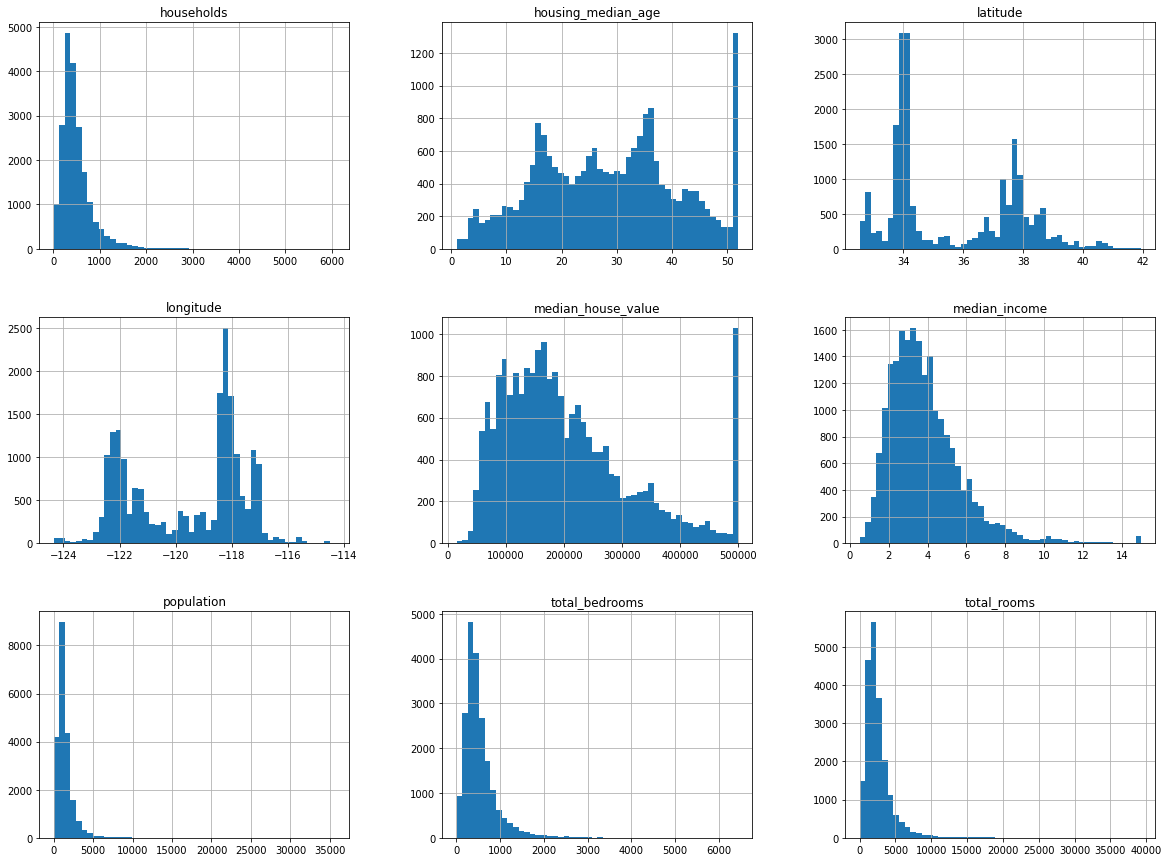

In [16]:
housing.hist(bins=50, figsize=(20,15));

1. A feature `median_income` não parece correta. Após checar com a fonte dos dados, vimos que esse número estar em dezenas de milhares milhares, mas que os valores maiores foram aparados (capped) para 15.0001 (150,000) e os menores para 0.4999
2. As features `housing_median_age` e `median_house_value` parecem ter passado por um tratamento de outliers também. O capped de `median_house_value` preocupa pois é nossa variável target, precisamos checar com os clientes se eles precisam de predições para valores acima de 500,000 dollars. De acordo com as respostas deles, temos 2 opções:
    - a) Coletar os valores reais para os distritos que tiveram o `target` aparado.
    - b) Remover esses distritos.
3. Os atributos têm escalas muito diferentes.
4. Muitos histogramas com right heavy skewed. Isso pode ser dificultar a percepção de padrões para alguns algoritmos de Machine Learning.

#### 4. Create a test set
Antes de fazer qualquer análise mais profunda, vamos dividir a parcela dos dados que não mais olharemos e servirá para avaliar nossos modelos futuramente.

Pode parecer estranha a ideia de não mais olharmos o set de test, mas nosso cérebro é ótimo em identificar padrões. Portanto, olhar essa parcela de teste pode nos induzir a usar um modelo de Machine Learning que será ótimo para o test set, e isso se refletirá nas métricas, mas, quando for posto em produção, possivelmente veremos que ele não está tão bom quanto esperávamos ao generalizar.

In [30]:
np.random.permutation(10)

array([8, 2, 7, 4, 3, 1, 9, 5, 0, 6])

In [31]:
int(10 * 0.20)

2

In [32]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [33]:
train_set, test_set = split_train_test(housing, 0.2)

train_set.shape, test_set.shape

((16512, 10), (4128, 10))

Apesar desse split funcionar, ele não é perfeito porque se o notebook rodar novamente, teremos conjuntos de treino e de test diferentes. Com o tempo, o modelo já terá rodado com todo o dataset, e não queremos isso.

Possíveis soluções de imediato:
- Salvar o conjunto de teste na primeira vez que rodar e recarregá-lo futuramente.
- Configurar a random seed antes de chamar np.random.permutation()

Mas ainda teremos um problema caso o dataset seja atualizado. Para ter conjuntos de treino e teste estáveis mesmo após update do dataset, uma solução é usar o identificador único de cada caso para decidir se ele vai ou nao para o conjunto de teste.

In [65]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

In [66]:
housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Todos esses métodos se tratam de amostragem aleatória simples. Se o dataset original for grande o suficiente, esse tipo de amostragem estará geralmente okay. Caso contrário, poderemos estar introduzindo sampling bias.

Após conversar com especialistas que fazem a inferência atualmente, eles disseram que `median_income` é um atributo bastante importante para inferir a nossa variável target `median_housing_prices`. Portanto, precisamos garantir que o test set é representativo das várias range de `median_income` do dataset inteiro.

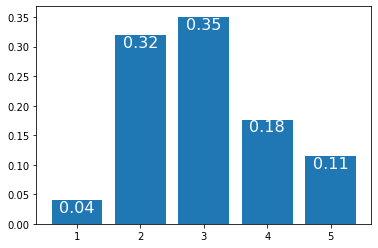

In [71]:
bins = [0., 1.5, 3.0, 4.5, 6., np.inf]
labels = [1, 2, 3, 4, 5]

housing["income_cat"] = pd.cut(housing["median_income"], bins=bins, labels=labels)

prop_inc_cat = housing["income_cat"].value_counts(normalize=True).sort_index()

plt.bar(prop_inc_cat.index, prop_inc_cat.values)

for a, b in zip(prop_inc_cat.index, prop_inc_cat.values):
    plt.text(a, b, np.round(b, 2), ha="center", va="top", color="white", fontsize=16)

In [78]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_index, test_index = list(split.split(housing, housing["income_cat"]))[0]

strat_train_set = housing.loc[train_index]
strat_test_set = housing.loc[test_index]

In [79]:
np.round(strat_test_set["income_cat"].value_counts(normalize=True).sort_index(), 2)

1    0.04
2    0.32
3    0.35
4    0.18
5    0.11
Name: income_cat, dtype: float64

In [80]:
strat_train_set.shape, strat_test_set.shape

((16512, 11), (4128, 11))

In [81]:
# Dropping income_cat from attributes
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True, errors="ignore")

#### 5. Discover and visualize the data to gain insights

In [82]:
# Putting test set apart
housing = strat_train_set.copy()

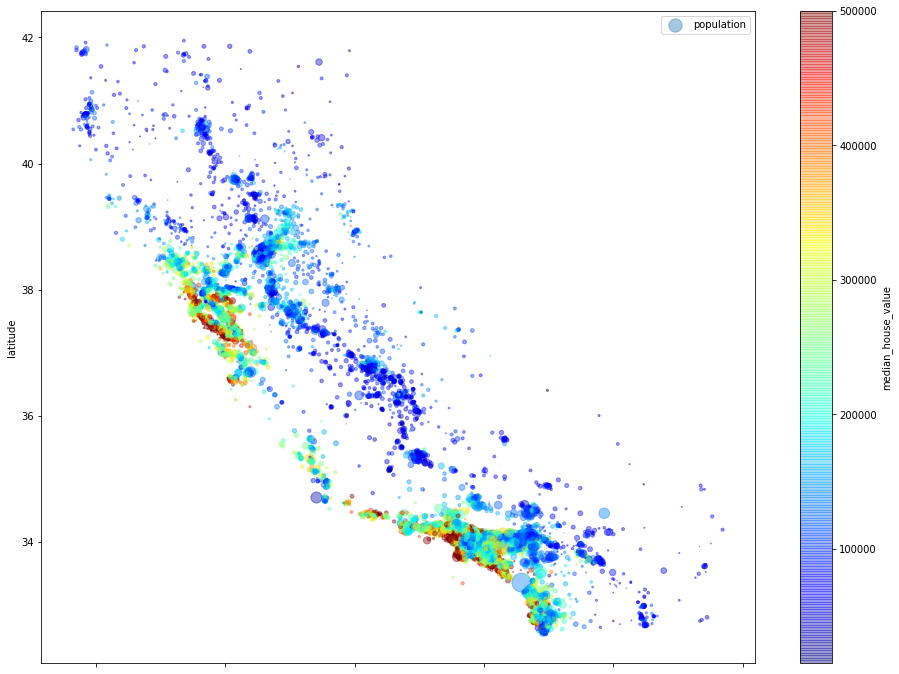

In [84]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(16, 12),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend();

O gráfico nos mostra que o preço da habitação é muito relacionado à localidade e à densidade populacional.

Um algoritmo de clustering pode ser útil, pois, a partir dos clusters, podemos criar novas features que medem a proximidade aos centroids dos clusters.

Além disso, vemos que a proximidade ao mar é um atributos que será bastante importante na inferência, apesar de que existem regiões próximas ao mar que não são tão caras, portanto não se trata de uma regra simples.

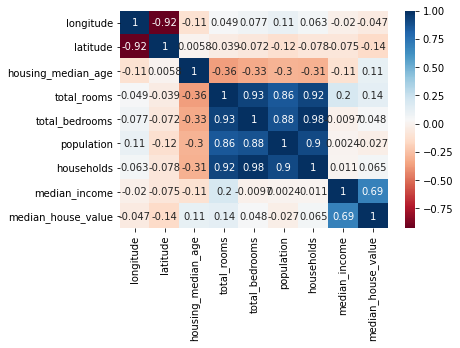

In [85]:
corr_matrix = housing.corr()

sns.heatmap(corr_matrix, cmap="RdBu", annot=True);

Podemos estar deixando de ver correlações não lineares com essa matriz

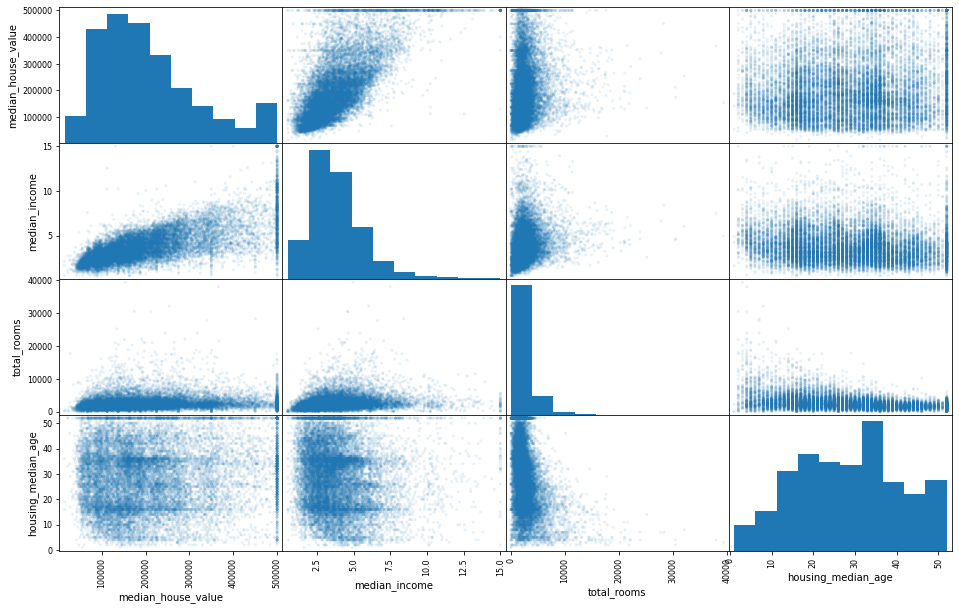

In [86]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], alpha=.1, figsize=(16, 10));

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

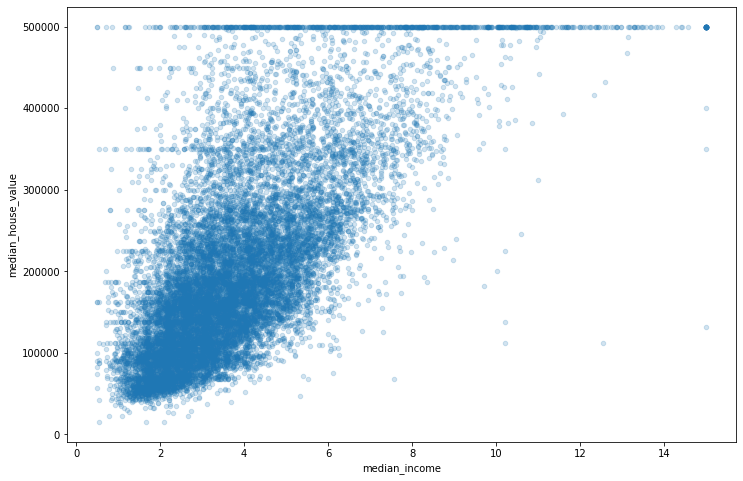

In [87]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, figsize=(12, 8))

#### 6. Experimentation with attribute combinations

In [88]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [89]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Essa etapa de exploração dos dados não precisa ser absolutamente completa.
O ponto aqui é começar com o pé direito e ganhar insights rápidos de como conseguir um primeiro protótipo razoavelmente bom.
Mas, por se tratar de um processo iterativo, uma vez que prototipamos o primeiro modelo, podemos analisar o output e conseguir mais insights para voltar a esse passo de exploração.

#### 7. Prepare the data for Machine Learning Algorithms

It’s time to prepare the data for your Machine Learning algorithms. Instead of doing this manually, you should write functions for this purpose, for several good reasons:

1. This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).

2. You will gradually build a library of transformation functions that you can reuse in future projects.

3. You can use these functions in your live system to transform the new data before feeding it to your algorithms.

4. This will make it possible for you to easily try various transformations and see which combination of transformations works best.

In [90]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

A maioria dos algoritmos de Machine Learning não sabe lidar com valores nulos, vimos que existem distritos onde total_bedrooms está nulo.
Temos 3 opções:
1. Dropar esses distritos.
2. Dropar o atributo inteiro.
3. Atribuir valores.

In [94]:
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

In [ ]:
imputer.statistics_

In [ ]:
housing_num.median().values

In [ ]:
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

#### Handling text and categorical attributes

A maioria dos algoritmos de ML prefere trabalhar com números, então vamos converter as categorias de texto para números.

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

##### Ordinal Encoder

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:10]

In [ ]:
ordinal_encoder.categories_

##### One-hot Encoder
O problema do Ordinal Encoder é que o MachineLearning vai assumir que dois valores próximos são mais similares do que valores distantes. Essa abordagem é ótima para categorias ordenadas como "ótimo", "bom", "mais ou menos" e "ruim", mas esse não é o nosso caso.

Uma solução comum é criar um atributo binário para cada categoria. Isso se chama **one-hot encoding**.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

In [ ]:
housing_cat_1hot.toarray()

In [ ]:
cat_encoder.categories_

Caso o atributo categórico tenha muitas categorias, o resultado do one-hot encoding será muitas features. Isso pode atrapalhar a performance do treinamento. Se isso acontecer, você poderia trocar a categoria por features numéricas relacionadas às categorias. Por exemplo, poderíamos trocar ocean_proximity pela distância ao oceano.

#### Custom transformers

Apesar do Scikit-Learn fornecer muitos transformadores úteis, você precisará escrever alguns para tarefas como operações de limpeza ou combinação de atributos específicos. 

Vamos querer que nosso transformador trabalhe perfeitamente com funcionalidades do Scikit-Learn (como pipelines), portanto, tudo que precisamos fazer é criar classes que implementem três métodos:
- fit() 
- transform()
- fit_transform()

Nós conseguimos o último facilmente adicionando o TransformerMixin como uma classe base. Se você adicionar BaseEstimator como uma classe, você também receberá dois métodos extras (get_params() e set_params()) que serão úteis para o tuning automático dos hyperparâmetros.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

#### Feature Scaling

Uma das transformações mais importantes a se aplicar nos dados é a feature scaling. Com poucas exceções, algoritmos de ML não performam bem quando os inputs estão em escalas muito diferentes.

Existem duas formas comuns de jogar todos os atributos na mesma escala:
- **Min-max Scaling**: Muitas vezes chamado de normalização. Os valores são re-escalados para que passem a variar entre 0 e 1
    
- **Standardization**: Subtrai dos valores a média do vetor (assim, passaremos a ter média 0) e divide pelo standard deviation. Diferente do Min-max Scaling, não limita os valores a um intervalo específico, o que pode ser problema para alguns algoritmos (redes neurais que esperam por valores entre 0 e 1). A vantagem deste, é que é muito menos afetado por outliers.

#### WARNING
Como em todas as transformações, é importante ajustar os re-escaladores apenas ao conjunto de treino e depois aplicar ao conjunto de teste e aos novos dados.

#### Transformation Pipelines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

O método construtor do Pipeline pega uma lista com os pares nome + estimator definindo uma sequência de passos. Todos, exceto o último estimator, devem ser transformers (eles devem ter o método fit_transform()). Os nome podem ser qualquer um que você queira.

Até agora, nós lidamos com as colunas categóricas e colunas numéricas separadamente. Seria mais conveniente ter um único transforme capaz de lidar com todas as colunas, aplicando as transformações apropriadas para cada coluna. 


In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

#### TIP
Ao invés de usar um transformer, você pode especificar a string "drop" para dropar colunas, ou "passthrough" se você quiser deixar algumas colunas intocadas. Por default, as colunas restantes serão dropadas.

#### Select and Train a Model

Enfim, entendemos o problema, conseguimos os dados e o exploramos, dividimos os conjuntos de treino e teste, e escrevemos algumas pipelines de transformação para limpeza e preparação dos dados. Estamos prontos para selecionar treinar o algoritmo de ML.

#### Training and Evaluating on the Training Set

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
some_data = housing.iloc[:3]
some_labels = housing_labels.iloc[:3]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", np.round(lin_reg.predict(some_data_prepared)))
print("Labels:", list(some_labels))

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.round(np.sqrt(lin_mse), 2)
lin_rmse

O modelo é melhor que nada, mas o score não está bom.

In [ ]:
plt.hist(housing_labels);

#### Underfitting
Esse é um exemplo de um modelo que está underfitting os dados de treinamento. Quando isso acontece, isso pode significar:
- As features não provêm informação suficiente para fazer predições
- O modelo não é poderoso o suficiente

Uma das principais formas de corrigir underfitting é selecionar modelos mais poderosos, alimentar o algoritmo de treino com features melhores, ou eliminar restrições.

A princípio, vamos tentar um modelo mais complexo.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

#### Overfitting
Neste caso, o modelo poderia estar absolutamente perfeito, mas é muito mais provável que o modelo está overfitting. 

O ideal é não tocar no conjunto de teste antes de ter um modelo pronto para ser posto em produção, então, precisaremos usar parte do conjunto de treinamento para treino e parte para validação do modelo.

# THE END

#### Better Evaluation Using Cross-Validation
Uma forma de avaliar o modelo de Decision Tree seria usar o train_test_split() para dividir o conjunto de treino em um conjunto menor de treinamento + um conjunto de validação, então, treinar os modelos com o conjunto menor de treinamento  e avaliar ele com o conjunto de validação.

Uma ótima alternativa é usar K-fold Cross-Validation. O código a seguir divide o conjunto de treino em 10 sub-conjuntos distintos e os chama de folds, então treina e avalia o modelo de Decision Tree 10 vezes, usando, a cada iteração, um fold para avaliação e os 9 restantes para treino. O resultado é um vetor contendo 10 scores de avaliação.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

#### WARNING

**O Cross-Validation do Scikit-Learn espera uma `utility function` (maior é melhor) ao invés de uma `cost function` (maior é pior), então a scoring function deve ser o oposto de MSE, que é o motivo pelo qual os códigos a seguir computam scores negativos antes de calcular a raiz quadrada**

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,407, generally ±2,439. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

Let’s compute the same scores for the Linear Regression model just to be sure:

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Let’s try one last model now: the RandomForestRegressor. As we will see in Chapter 7, Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further. We will skip most of the code since it is essentially the same as for the other models:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Wow, this is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. Before you dive much deeper into Random Forests, however, you should try out many other models from various categories of Machine Learning algorithms (e.g., several Support Vector Machines with different kernels, and possibly a neural network), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

#### Fine-Tune Your Model
Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them. Let’s look at a few ways you can do that.

#### Grid Search

One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead, you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

#### TIP
When you have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10 (or a smaller number if you want a more fine-grained search, as shown in this example with the n_estimators hyperparameter).

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("Score: {:<25} Params: {}".format(np.sqrt(-mean_score), params))

In this example, we obtain the best solution by setting the max_features hyperparameter to 8 and the n_estimators hyperparameter to 30. The RMSE score for this combination is 49,682, which is slightly better than the score you got earlier using the default hyperparameter values (which was 50,182). Congratulations, you have successfully fine-tuned your best model!

#### TIP
Don’t forget that you can treat some of the data preparation steps as hyperparameters. For example, the grid search will automatically find out whether or not to add a feature you were not sure about (e.g., using the add_bedrooms_per_room hyperparameter of your CombinedAttributesAdder transformer). It may similarly be used to automatically find the best way to handle outliers, missing features, feature selection, and more.